In [124]:
##Create lineups libraries
import pandas as pd
import numpy as np
from itertools import combinations
import random
import os
import time
from tqdm import tqdm
import datetime

##Create imitation distributions libraries
from random import triangular
import random
import numpy as np

##Create random sample point array from player distribution libraries
import scipy.interpolate as interpolate
from pga.return_pid import return_pid
from pga.fuzz_match import return_tid
from scipy import stats

##Simulate Annealing libraries
from collections import Counter
import itertools

In [126]:
##Create Lineups

##User defined variables
#num lineups in tournament
num_lineups = 36700

#cumulative ownership for the field
cum_per_owned = 6

#Read salaries and ownership
player_df = pd.read_csv('/home/valesco/Datasets/PGA_Data/salary_folder/pga_champ_salaries.csv')

start = datetime.datetime.now()

######### Find a way to randomize lineup creation to avoid having biases in combinations between the players
######### due to location in the dictionary

#Functions
def random_combination(iterable, r, player): 
    #Random selection from combinations
    iter_count = 0 
    combo_salary = 0
    salary_ls = []
    while combo_salary < 48800 or combo_salary > 50000:
        iter_count += 1
        if iter_count > 60000:
            if player == 'placeholder':
                print('placeholder error')
                
            else:
                print('combination impossible')
                
            return salary_ls
        
        if r == 5:
            combo_salary = salary_dict[player]
        else:
            combo_salary = 0
        
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        team = tuple(pool[i] for i in indices)
        
        for t in team:
            combo_salary += salary_dict[t]
        
        salary_ls.append(tuple((team, combo_salary)))
        
    return tuple(pool[i] for i in indices)


def random_lineup_generator(iterable, r, lineups_to_create, player):
    temp_ls = []
    for i in range(lineups_to_create):
        
        temp_ls.append(random_combination(iterable, r, player))
    
    return temp_ls


def lineup_difference (p, player):
    curr_df_len = len(lineup_df)

    adjust_df_len = num_lineups - curr_df_len

    target_own = pid_dict[p]['own']
    target_lus = round(target_own * num_lineups) + adjust_df_len

    actual_lus = count_df['count'].loc[count_df['name'] == player].values[0]

    lu_diff = int(target_lus - actual_lus)
    
    return lu_diff

##Create return_ownership

def return_ownership(player):
    for key, value in pid_dict.items():
        if value['name'] == player:
            return value['own']


player_df = player_df[player_df['owned'] > 0]
player_df['temp_pid'] = player_df['salary'].rank(ascending = False, method = 'first') - 1
player_df['temp_pid'] = player_df['temp_pid'].map(lambda x: int(x))
player_df.reset_index(inplace = True, drop = True)

players = list(player_df['name'].values)
salary_dict = dict(zip(player_df['name'], player_df['salary']))

pid_dict = {}

for p, player in enumerate(players):
    salary = player_df['salary'].loc[player_df['name'] == player].values[0]
    own = player_df['owned'].loc[player_df['name'] == player].values[0]
    pid_dict[p] = {'name': player, 'salary': salary, 'own': own, 'lineup_diff': 0}

pids = list(pid_dict.keys())

#generate random num lineups for tournament
random_lineups = random_lineup_generator(players, 6, num_lineups, 'player')

lineup_df = pd.DataFrame(random_lineups)

#Count players in lineups
count_df = lineup_df.apply(pd.Series.value_counts)

#Turn counts into percent
count_df['count'] = count_df.sum(axis = 1)
count_df.reset_index(inplace = True)
count_df.rename(columns = {'index': 'name'}, inplace = True)
count_df['owned'] = count_df['name'].apply(lambda x: return_ownership(x))
count_df['target_lus'] = count_df['owned'] * num_lineups
count_df['lu_diff'] = 0




for iteration in tqdm(range(6)):
    for p, player in tqdm(enumerate(players)):
        
        lu_diff = lineup_difference(p, player)

        if lu_diff > 0:
            
            #Create list teams of 5 players without current player
            if p < 1:
                temp_player_ls = list(player_df['name'].unique())
                temp_player_ls.remove(player)
                
                if len(temp_player_ls) < 5:
                    print('error')
            else:
                temp_player_ls = list(count_df['name'].loc[count_df['lu_diff'] > 0].unique())
                temp_player_ls.remove(player)
                
            temp_5_man_lus = random_lineup_generator(temp_player_ls, 5, lu_diff, player)   

            #Add player to 5 man combos
            temp_lus = []
            for t, lu in enumerate(temp_5_man_lus):
                temp_lus.append(lu + (player,))

            temp_df = pd.DataFrame(temp_lus)

            #replace teams in lineup_df

            #select random indexs len num of lineups to replace
            removal_index = sorted(random.sample(range(num_lineups), lu_diff))

            new_df = lineup_df.loc[~lineup_df.index.isin(removal_index)]

            lineup_df = pd.concat([new_df, temp_df])
            lineup_df.reset_index(inplace = True, drop = True)


        if lu_diff < 0:
            lu_diff = abs(lu_diff)

            # Create 6 man teams to replace teams with player
            if p < 1:
                temp_player_ls = list(player_df['name'].unique())
                temp_player_ls.remove(player)
                
                if len(temp_player_ls) < 6:
                    print('error')

            else:
                temp_player_ls = list(count_df['name'].loc[count_df['lu_diff'] > -200].unique())
                #temp_player_ls.remove(player)

            temp_6_man_lus = random_lineup_generator(temp_player_ls, 6, lu_diff, 'placeholder')
            temp_df = pd.DataFrame(temp_6_man_lus)

            #Remove existing lineups with player in them
            removal_index = lineup_df[lineup_df.apply(lambda x: x.str.contains(player, case = False).any(),
                                                      axis = 1)].sample(frac=1).head(lu_diff).index

            new_df = lineup_df.loc[~lineup_df.index.isin(removal_index)]

            lineup_df = pd.concat([new_df, temp_df])
            lineup_df.reset_index(inplace = True, drop = True)
            
            

        count_df = lineup_df.apply(pd.Series.value_counts)

        #Turn counts into percent
        count_df['count'] = count_df.sum(axis = 1)
        count_df.reset_index(inplace = True)
        count_df.rename(columns = {'index': 'name'}, inplace = True)
        count_df['owned'] = count_df['name'].apply(lambda x: return_ownership(x))
        count_df['target_lus'] = count_df['owned'] * num_lineups
        count_df['lu_diff'] = count_df['target_lus'] - count_df['count']
        
print(datetime.datetime.now() - start)


  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:07,  7.01s/it]

3it [00:13,  5.88s/it]
4it [00:13,  4.15s/it]
6it [00:20,  3.87s/it]
7it [00:26,  4.53s/it]
8it [00:32,  4.96s/it]
9it [00:43,  7.06s/it]
11it [00:44,  4.96s/it]
13it [00:50,  4.44s/it]
14it [00:56,  4.93s/it]
17it [01:02,  4.05s/it]
18it [01:08,  4.61s/it]
19it [01:14,  4.98s/it]
21it [01:20,  4.37s/it]
23it [01:26,  3.94s/it]
25it [01:32,  3.64s/it]
26it [01:37,  4.31s/it]
27it [01:43,  4.77s/it]
30it [01:49,  3.93s/it]
32it [01:55,  3.63s/it]
33it [02:01,  4.31s/it]
34it [02:07,  4.78s/it]
35it [02:13,  5.11s/it]
36it [02:18,  5.29s/it]
37it [02:24,  5.44s/it]
38it [02:24,  3.84s/it]
39it [02:30,  4.42s/it]
41it [02:30,  3.12s/it]
42it [02:36,  3.94s/it]
43it [02:42,  4.50s/it]
44it [02:48,  4.87s/it]
45it [02:53,  5.18s/it]
46it [02:59,  5.39s/it]
47it [03:05,  5.55s/it]
48it [03:11,  5.63s/it]
49it [03:17,  5.69s/it]
51it [03:17,  4.00s/it]
52it [03:23,  4.55s/it]
53it [03:29,  4.92s/it]
54it [03:3

0:48:42.468791


In [127]:
### Create imitation playerdistributions

def bimodal(low1, high1, mode1, low2, high2, mode2, cutoff, num_samples):
    toss = random.randint(0, 100)
    
    if toss >= cutoff:
        return triangular(low1, high1, mode1)
    
    else:
        return triangular(low2, high2, mode2)
    
def create_distro(cutmade_ceiling, cutmissed_ceiling, cutmade_percent, num_samples):
    distro = []
    
    cutmade_mode = (cutmade_ceiling - cutmissed_ceiling) / 2 + cutmissed_ceiling
    cutmissed_mode = cutmissed_ceiling / 2
    
    for i in range(num_samples):
        distro.append(round(bimodal(0, cutmissed_ceiling, cutmissed_mode, cutmissed_ceiling, cutmade_ceiling,
                                    cutmade_mode, cutmade_percent, num_samples)))
    return distro

def create_arrays(best_madecut_ceiling, best_missedcut_ceiling, best_cutmade_percent, num_players):
    madecut_ceiling_array = np.linspace(best_madecut_ceiling, best_madecut_ceiling - 30, num_players)
    missedcut_ceiling_array = np.linspace(best_missedcut_ceiling, best_missedcut_ceiling - 15, num_players)
    cutmade_percent_array = np.linspace(best_cutmade_percent, 10, num_players)
    
    return madecut_ceiling_array, missedcut_ceiling_array, cutmade_percent_array

def create_all_player_distros(madecut_ceiling_array, missedcut_ceiling_array, cutmade_percent_array, player_ls,
                             num_samples):
    player_dict = {}
    
    for i, player in enumerate(player_ls):
        temp_distro = []
        
        jostle = random.uniform(.93, 1.07)
        cutmade_ceiling = madecut_ceiling_array[i] * jostle
        cutmissed_ceiling = missedcut_ceiling_array[i] * jostle
        cutmade_percent = cutmade_percent_array[i] * jostle
        temp_distro.append(create_distro(cutmade_ceiling, cutmissed_ceiling, cutmade_percent, num_samples))
        player_dict[player] = temp_distro

    return player_dict

##User defined values
best_madecut_ceiling = 100
best_missedcut_ceiling = 40
best_cutmade_percent = 90
num_samples = 200
sal_player_ls = list(player_df['name'].values)



#Create the ceiling arrays
madecut_ceiling_array, missedcut_ceiling_array, cutmade_percent_array = create_arrays(best_madecut_ceiling,
                                                        best_missedcut_ceiling, best_cutmade_percent, 125)

player_distro_dict = create_all_player_distros(madecut_ceiling_array, missedcut_ceiling_array, cutmade_percent_array,
                                    sal_player_ls, num_samples)

In [178]:
## Create sample simulation point array
def myround(x, base):
    return (int(base * round(float(x) / base)))

def inverse_transform_sampling(data, n_bins, n_samples):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    
    return inv_cdf(r)


def create_points_array(player_df, num_sims):  ##tourny_avg, tourny_std):
    proj_array = np.zeros((len(player_df), num_sims + 1)).astype(np.int16)

    for index, row in player_df.iterrows():
        ##Start point distribution with temp_pid
        temp_pid = np.array(row['temp_pid']).reshape(1,1)
        player_name = row['name']
        

        point_array = player_distro_dict[player_name]
        rand_array = inverse_transform_sampling(point_array, 50, num_sims)
        
        #Not including normalized points in this initial run
        #point_sims = rand_array * tourny_std + tourny_avg
        #flat_sim = np.round(point_sims.reshape((1, num_sims)), decimals = 0)
        flat_sim = np.round(rand_array.reshape((1, num_sims)), decimals = 0)

        flat_sim = np.hstack((temp_pid, flat_sim))

        proj_array[index] = flat_sim


    return proj_array

proj_array = create_points_array(player_df, 1000)


In [129]:
## Map temp pid to lineup array to create contest array

temp_pid_dict = dict(zip(player_df['name'].values, player_df['temp_pid']))

pid_lineups = pd.DataFrame()

pid_lineups[0] = lineup_df[0].map(lambda x: temp_pid_dict[x])
pid_lineups[1] = lineup_df[1].map(lambda x: temp_pid_dict[x])
pid_lineups[2] = lineup_df[2].map(lambda x: temp_pid_dict[x])
pid_lineups[3] = lineup_df[3].map(lambda x: temp_pid_dict[x])
pid_lineups[4] = lineup_df[4].map(lambda x: temp_pid_dict[x])
pid_lineups[5] = lineup_df[5].map(lambda x: temp_pid_dict[x])

contest_array = pid_lineups.as_matrix()
contest_array

array([[  0,  10,  15,  35,  45,  97],
       [  6,   8,   9,  28,  47,  61],
       [  1,   4,  35,  57,  71,  75],
       ..., 
       [  9,  95,  12,   1,  71, 111],
       [ 57,   4,  78,   1,  71, 111],
       [  9,  57,   4,  59,   8, 111]])

In [130]:
###Create Payout Array
def create_payout_array(num_lineups, buyin):
    payout_ls = []
    for i in range(num_lineups):
        if i == 0:
            payout_ls.append(25000 - buyin)
        elif i == 1:
            payout_ls.append(15000 - buyin)
        elif i == 2:
            payout_ls.append(10000 - buyin)
        elif i == 3: 
            payout_ls.append(5000 - buyin)
        elif i == 4: 
            payout_ls.append(4000 - buyin) #.145
        elif i == 5:
            payout_ls.append(3000 - buyin) #.145 + .06 = .205
        elif i == 6: 
            payout_ls.append(2000 - buyin) # .205 + .064 = .269
        elif i == 7:
            payout_ls.append(1500 - buyin) # .269 + .10 = .369
        elif i == 8 or i == 9: 
            payout_ls.append(1000 - buyin) # .369 + .16 = .549
        elif i == 10 or i == 11:
            payout_ls.append(700 - buyin) 
        elif i == 12 or i == 13:
            payout_ls.append(600 - buyin)
        elif i == 14 or i == 15 or i == 16:
            payout_ls.append(500 - buyin)
        elif i == 17 or i == 18 or i == 19:
            payout_ls.append(400 - buyin)
        elif i > 19 and i <= 29:
            payout_ls.append(300 - buyin)
        elif i > 29 and i <= 39:
            payout_ls.append(250 - buyin)
        elif i > 39 and i <= 54:
            payout_ls.append(200 - buyin)
        elif i > 54 and i <= 69:
            payout_ls.append(150 - buyin)
        elif i > 69 and i <= 109:
            payout_ls.append(100 - buyin)
        elif i > 109 and i <= 159:
            payout_ls.append(70 - buyin)
        elif i > 159 and i <= 259:
            payout_ls.append(60 - buyin)
        elif i > 259 and i <= 359:
            payout_ls.append(50 - buyin)
        elif i > 359 and i <= 459:
            payout_ls.append(40 - buyin)
        elif i > 459 and i <= 659:
            payout_ls.append(35 - buyin)
        elif i > 659 and i <= 959:
            payout_ls.append(30 - buyin)
        elif i > 959 and i <= 1609:
            payout_ls.append(25 - buyin)
        elif i > 1609 and i <= 2619:
            payout_ls.append(20 - buyin)
        elif i > 2619 and i <= 5119:
            payout_ls.append(15 - buyin)
        elif i > 5119 and i <= 9619:
            payout_ls.append(12 - buyin)
        else:
            payout_ls.append(-1 * buyin)
            
    return payout_ls
            
payout_array = create_payout_array(36700, 8)
payout_array = np.array(payout_array).reshape(-1 , 1)
payout_array

array([[24992],
       [14992],
       [ 9992],
       ..., 
       [   -8],
       [   -8],
       [   -8]])

In [ ]:
payout_array[9619]

In [179]:
##Simulate tournaments

def create_first_team(player_ls, pid_dict, sal_dict):
    while True:
        team_salary = 0

        team = random.sample(player_ls, 6)
    
        for player in team:
            team_salary += sal_dict[player]
            
        if team_salary <= 50000 and team_salary > 48000:
            return team

def update_temp(i, t):
    temp = t / log(i)
    return temp
            
def cost(team):
    indices = np.arange(len(contest_array)).reshape(len(contest_array), 1)
    team_payout_ls = []
    
    team_ids = []
    
    for player in team:
        for key in pid_dict.keys():
            if pid_dict[key]['name'] == player:
                team_ids.append(key)

    for i in range(1,proj_array.shape[1]):

        #create dict of points 
        point_dict = dict(zip(proj_array[:,0], proj_array[:,i]))

        #select random int for replacement in contest array
        random_replacement = random.randint(0, len(contest_array) - 1)

        #create_temp array for replacement
        temp_contest_array = contest_array
        temp_contest_array[random_replacement] = team_ids

        #create sim array of points from single simulation
        sim_array = np.vectorize(point_dict.__getitem__)(temp_contest_array)

        #sum up team points for simulation
        total_points = sim_array.sum(axis = 1).reshape((len(sim_array),1))

        #create add indicies to total points
        result_array = np.hstack((indices, total_points))

        #sort result array by points decending
        result_array = result_array[result_array[:, 1].argsort()[::-1]]

        #add payout array to results array
        result_array = np.hstack((result_array, payout_array))

        #revert result array back to being order by index
        result_array = result_array[result_array[:,0].argsort()]

        #append team result to team payout list
        team_payout_ls.append(result_array[random_replacement, -1])
        
    ####temp_tracking
    cost_iteration_results.append({'team': team, 'payouts': team_payout_ls})
        
    return sum(team_payout_ls) / len(team_payout_ls)


####Track iterations of cost function
cost_iteration_results = []
            
def create_team(team, player_ls):
    counter = 0
    while True:
        new_team = team[:]
        team_salary = 0
        
        player_to_remove = random.randint(0, len(team) - 1)
        player_to_add = random.choice(player_ls)

        new_team[player_to_remove] = player_to_add
        
        for player in new_team:
            team_salary += salary_dict[player]
            
        duplicates = Counter(new_team)
        
        if team_salary <= 50000 and team_salary >= 48000 and len(duplicates.values()) == 6:
            return new_team
        
        counter += 1
        
        if counter > 1000:
            new_team = create_first_team(player_ls, pid_dict, salary_dict)
            return new_team
        
        
    
final_teams = []

for z in range(1):
    start = datetime.datetime.now()
    #initialize values for simulation
    first_team = create_first_team(players, pid_dict, salary_dict)
    max_iters = 300
    best_team = first_team[:]
    current_best = first_team[:]
    temp = 100
    temp_change = .995
    ev_ls = []
    temp_ls = []
    count = 50
    cost_curr = cost(current_best)
    
    for i in tqdm(range(max_iters)):        
        new_team = create_team(current_best, players)
        
        cost_new = cost(new_team)
        
            
        print(new_team, cost_new, current_best, cost_curr)
        if cost_new > cost_curr:
            current_best = new_team[:]
            cost_curr = cost_new
            ev_ls.append([current_best, cost_new])
    
        else:
            temp = temp * temp_change
            if temp < 0:
                temp = 100 - count
                if count < 100:
                    count += 7
            r = random.randint(1,120)
            
            if r < temp:
                print('worse team taken')
                current_best = new_team[:]
                cost_curr = cost_new
                ev_ls.append([current_best, cost_new])
                
        
    
    final_teams.append(current_best)

    print(datetime.datetime.now() - start)


  0%|          | 1/300 [04:47<23:52:28, 287.45s/it]

['Rory McIlroy', 'Byeong-Hun An', 'Bud Cauley', 'Grayson Murray', 'Henrik Stenson', 'Danny Lee'] -7.668 ['Rory McIlroy', 'Byeong-Hun An', 'Lee Westwood', 'Grayson Murray', 'Henrik Stenson', 'Danny Lee'] -7.152
worse team taken


  1%|          | 2/300 [09:30<23:41:31, 286.21s/it]

['Rory McIlroy', 'Byeong-Hun An', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Danny Lee'] -7.057 ['Rory McIlroy', 'Byeong-Hun An', 'Bud Cauley', 'Grayson Murray', 'Henrik Stenson', 'Danny Lee'] -7.668


  1%|          | 3/300 [14:13<23:32:02, 285.26s/it]

['Rory McIlroy', 'Matthew Fitzpatrick', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Danny Lee'] -5.672 ['Rory McIlroy', 'Byeong-Hun An', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Danny Lee'] -7.057


  1%|▏         | 4/300 [18:56<23:23:19, 284.46s/it]

['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Danny Lee'] -5.814 ['Rory McIlroy', 'Matthew Fitzpatrick', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Danny Lee'] -5.672
worse team taken


  2%|▏         | 5/300 [23:39<23:16:38, 284.06s/it]

['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Byeong-Hun An'] -4.129 ['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Danny Lee'] -5.814


  2%|▏         | 6/300 [28:23<23:12:04, 284.10s/it]

['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Charl Schwartzel'] -2.898 ['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Byeong-Hun An'] -4.129


  2%|▏         | 7/300 [33:05<23:03:25, 283.29s/it]

['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -2.283 ['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Charl Schwartzel'] -2.898


  3%|▎         | 8/300 [37:48<22:58:58, 283.35s/it]

['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Peter Uihlein', 'Henrik Stenson', 'Rafael Cabrera-Bello'] 0.485 ['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Graeme McDowell', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -2.283


  3%|▎         | 9/300 [42:30<22:52:16, 282.94s/it]

['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Jordan L. Smith', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -6.251 ['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Peter Uihlein', 'Henrik Stenson', 'Rafael Cabrera-Bello'] 0.485
worse team taken


  3%|▎         | 10/300 [47:16<22:52:25, 283.95s/it]

['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Jordan L. Smith', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -5.015 ['Rory McIlroy', 'Patrick Reed', 'Bud Cauley', 'Jordan L. Smith', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -6.251


  4%|▎         | 11/300 [52:05<22:53:55, 285.25s/it]

['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Danny Lee', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -4.117 ['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Jordan L. Smith', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -5.015


  4%|▍         | 12/300 [56:53<22:54:15, 286.30s/it]

['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Lee Westwood', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -2.762 ['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Danny Lee', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -4.117


  4%|▍         | 13/300 [1:01:40<22:49:07, 286.23s/it]

['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Andrew Johnston', 'Henrik Stenson', 'Rafael Cabrera-Bello'] 2.324 ['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Lee Westwood', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -2.762


  5%|▍         | 14/300 [1:06:26<22:44:57, 286.35s/it]

['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Bud Cauley', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -5.605 ['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Andrew Johnston', 'Henrik Stenson', 'Rafael Cabrera-Bello'] 2.324
worse team taken


  5%|▌         | 15/300 [1:11:11<22:38:36, 286.02s/it]

['Rory McIlroy', 'Patrick Reed', 'Jimmy Walker', 'Bud Cauley', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -4.291 ['Rory McIlroy', 'Patrick Reed', 'Jason Dufner', 'Bud Cauley', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -5.605


  5%|▌         | 16/300 [1:15:58<22:34:17, 286.12s/it]

['Rory McIlroy', 'Patrick Reed', 'Jimmy Walker', 'Bud Cauley', 'Henrik Stenson', 'Robert Streb'] -5.589 ['Rory McIlroy', 'Patrick Reed', 'Jimmy Walker', 'Bud Cauley', 'Henrik Stenson', 'Rafael Cabrera-Bello'] -4.291
worse team taken


  6%|▌         | 17/300 [1:20:44<22:29:15, 286.06s/it]

['Rory McIlroy', 'Patrick Reed', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -4.859 ['Rory McIlroy', 'Patrick Reed', 'Jimmy Walker', 'Bud Cauley', 'Henrik Stenson', 'Robert Streb'] -5.589


  6%|▌         | 18/300 [1:25:30<22:24:44, 286.11s/it]

['Rory McIlroy', 'Ryan Fox', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -7.061 ['Rory McIlroy', 'Patrick Reed', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -4.859
worse team taken


  6%|▋         | 19/300 [1:30:16<22:20:04, 286.14s/it]

['Rory McIlroy', 'Brendan Steele', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -5.035 ['Rory McIlroy', 'Ryan Fox', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -7.061


  7%|▋         | 20/300 [1:35:02<22:14:50, 286.04s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -6.401 ['Rory McIlroy', 'Brendan Steele', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -5.035
worse team taken


  7%|▋         | 21/300 [1:39:48<22:10:12, 286.07s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Brandon Stone'] -6.682 ['Rory McIlroy', 'Soren Kjeldsen', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -6.401


  7%|▋         | 22/300 [1:44:35<22:06:04, 286.20s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Jimmy Walker', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.314 ['Rory McIlroy', 'Soren Kjeldsen', 'Jimmy Walker', 'Hideto Tanihara', 'Henrik Stenson', 'Robert Streb'] -6.401


  8%|▊         | 23/300 [1:49:20<21:59:47, 285.88s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Anirban Lahiri', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.785 ['Rory McIlroy', 'Soren Kjeldsen', 'Jimmy Walker', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.314
worse team taken


  8%|▊         | 24/300 [1:54:06<21:55:19, 285.94s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Mackenzie Hughes', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -6.496 ['Rory McIlroy', 'Soren Kjeldsen', 'Anirban Lahiri', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.785
worse team taken


  8%|▊         | 25/300 [1:58:52<21:50:44, 285.98s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Luke Donald', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -6.215 ['Rory McIlroy', 'Soren Kjeldsen', 'Mackenzie Hughes', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -6.496


  9%|▊         | 26/300 [2:03:38<21:45:38, 285.91s/it]

['Rory McIlroy', 'Soren Kjeldsen', 'Steve Stricker', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.538 ['Rory McIlroy', 'Soren Kjeldsen', 'Luke Donald', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -6.215


  9%|▉         | 27/300 [2:08:24<21:41:18, 286.00s/it]

['Rory McIlroy', 'Kevin Chappell', 'Steve Stricker', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -3.963 ['Rory McIlroy', 'Soren Kjeldsen', 'Steve Stricker', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.538


  9%|▉         | 28/300 [2:13:09<21:35:56, 285.87s/it]

['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.334 ['Rory McIlroy', 'Kevin Chappell', 'Steve Stricker', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -3.963
worse team taken


 10%|▉         | 29/300 [2:17:56<21:32:05, 286.07s/it]

['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Robert Streb'] -4.321 ['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'William McGirt', 'Henrik Stenson', 'Robert Streb'] -5.334


 10%|█         | 30/300 [2:22:42<21:27:47, 286.17s/it]

['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Steve Stricker'] -5.21 ['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Robert Streb'] -4.321


 10%|█         | 31/300 [2:27:29<21:23:50, 286.36s/it]

['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Louis Oosthuizen'] -3.444 ['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Robert Streb'] -4.321


 11%|█         | 32/300 [2:32:15<21:18:37, 286.26s/it]

['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Bryson DeChambeau'] -4.608 ['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Louis Oosthuizen'] -3.444
worse team taken


 11%|█         | 33/300 [2:37:01<21:13:49, 286.25s/it]

['Rory McIlroy', 'Padraig Harrington', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Bryson DeChambeau'] -3.967 ['Rory McIlroy', 'Kevin Chappell', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Bryson DeChambeau'] -4.608


 11%|█▏        | 34/300 [2:41:47<21:08:26, 286.11s/it]

['Rory McIlroy', 'Padraig Harrington', 'David Lingmerth', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -5.745 ['Rory McIlroy', 'Padraig Harrington', 'David Lingmerth', 'Ryan Moore', 'Henrik Stenson', 'Bryson DeChambeau'] -3.967
worse team taken


 12%|█▏        | 35/300 [2:46:34<21:04:01, 286.19s/it]

['Rory McIlroy', 'Kyle Stanley', 'David Lingmerth', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -5.002 ['Rory McIlroy', 'Padraig Harrington', 'David Lingmerth', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -5.745


 12%|█▏        | 36/300 [2:51:20<20:59:52, 286.34s/it]

['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -4.972 ['Rory McIlroy', 'Kyle Stanley', 'David Lingmerth', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -5.002


 12%|█▏        | 37/300 [2:56:05<20:53:19, 285.93s/it]

['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -5.263 ['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -4.972
worse team taken


 13%|█▎        | 38/300 [3:00:52<20:49:43, 286.20s/it]

['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Padraig Harrington', 'Henrik Stenson', 'Bryson DeChambeau'] -3.405 ['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Graham DeLaet', 'Henrik Stenson', 'Bryson DeChambeau'] -5.263


 13%|█▎        | 39/300 [3:05:39<20:45:25, 286.31s/it]

['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Chez Reavie', 'Henrik Stenson', 'Bryson DeChambeau'] -6.764 ['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Padraig Harrington', 'Henrik Stenson', 'Bryson DeChambeau'] -3.405
worse team taken


 13%|█▎        | 40/300 [3:10:24<20:39:18, 285.99s/it]

['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Chez Reavie', 'Henrik Stenson', 'Anirban Lahiri'] -7.008 ['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Chez Reavie', 'Henrik Stenson', 'Bryson DeChambeau'] -6.764
worse team taken


 14%|█▎        | 41/300 [3:15:10<20:34:18, 285.94s/it]

['Rory McIlroy', 'Kyle Stanley', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Anirban Lahiri'] -5.058 ['Rory McIlroy', 'Kyle Stanley', 'Cody Gribble', 'Chez Reavie', 'Henrik Stenson', 'Anirban Lahiri'] -7.008


 14%|█▍        | 42/300 [3:19:56<20:30:21, 286.13s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Anirban Lahiri'] -6.689 ['Rory McIlroy', 'Kyle Stanley', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Anirban Lahiri'] -5.058
worse team taken


 14%|█▍        | 43/300 [3:24:42<20:24:54, 285.97s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Tyrrell Hatton'] -6.712 ['Rory McIlroy', 'Patrick Cantlay', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Anirban Lahiri'] -6.689
worse team taken


 15%|█▍        | 44/300 [3:29:28<20:20:39, 286.09s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Tyrrell Hatton'] -6.74 ['Rory McIlroy', 'Patrick Cantlay', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Tyrrell Hatton'] -6.712
worse team taken


 15%|█▌        | 45/300 [3:34:14<20:16:05, 286.14s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Chez Reavie', 'Henrik Stenson', 'Tyrrell Hatton'] -7.728 ['Rory McIlroy', 'Patrick Cantlay', 'Graeme McDowell', 'Chez Reavie', 'Henrik Stenson', 'Tyrrell Hatton'] -6.74
worse team taken


 15%|█▌        | 46/300 [3:39:01<20:12:03, 286.31s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Branden Grace', 'Henrik Stenson', 'Tyrrell Hatton'] -5.82 ['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Chez Reavie', 'Henrik Stenson', 'Tyrrell Hatton'] -7.728


 16%|█▌        | 47/300 [3:43:48<20:08:05, 286.51s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Danny Lee', 'Henrik Stenson', 'Tyrrell Hatton'] -7.48 ['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Branden Grace', 'Henrik Stenson', 'Tyrrell Hatton'] -5.82
worse team taken


 16%|█▌        | 48/300 [3:48:34<20:03:09, 286.47s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Danny Lee', 'Henrik Stenson', 'Louis Oosthuizen'] -6.471 ['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Danny Lee', 'Henrik Stenson', 'Tyrrell Hatton'] -7.48


 16%|█▋        | 49/300 [3:53:21<19:58:04, 286.39s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Anirban Lahiri', 'Henrik Stenson', 'Louis Oosthuizen'] -6.198 ['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Danny Lee', 'Henrik Stenson', 'Louis Oosthuizen'] -6.471


 17%|█▋        | 50/300 [3:58:08<19:54:04, 286.58s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Anirban Lahiri', 'Henrik Stenson', 'Louis Oosthuizen'] -2.246 ['Rory McIlroy', 'Patrick Cantlay', 'Younghan Song', 'Anirban Lahiri', 'Henrik Stenson', 'Louis Oosthuizen'] -6.198


 17%|█▋        | 51/300 [4:02:54<19:49:04, 286.52s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Bud Cauley', 'Henrik Stenson', 'Louis Oosthuizen'] -4.107 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Anirban Lahiri', 'Henrik Stenson', 'Louis Oosthuizen'] -2.246
worse team taken


 17%|█▋        | 52/300 [4:07:39<19:42:42, 286.14s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Jim Furyk', 'Henrik Stenson', 'Louis Oosthuizen'] -4.938 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Bud Cauley', 'Henrik Stenson', 'Louis Oosthuizen'] -4.107


 18%|█▊        | 53/300 [4:12:26<19:38:21, 286.24s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Henrik Stenson', 'Louis Oosthuizen'] 0.988 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Bud Cauley', 'Henrik Stenson', 'Louis Oosthuizen'] -4.107


 18%|█▊        | 54/300 [4:17:12<19:33:04, 286.12s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Henrik Stenson', 'Kelly Kraft'] -2.883 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Henrik Stenson', 'Louis Oosthuizen'] 0.988


 18%|█▊        | 55/300 [4:21:57<19:26:58, 285.79s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Henrik Stenson', 'Steve Stricker'] -2.71 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Henrik Stenson', 'Louis Oosthuizen'] 0.988
worse team taken


 19%|█▊        | 56/300 [4:26:43<19:23:02, 286.00s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Justin Rose', 'Steve Stricker'] -0.746 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Henrik Stenson', 'Steve Stricker'] -2.71


 19%|█▉        | 57/300 [4:31:29<19:18:36, 286.08s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Sergio Garcia', 'Steve Stricker'] 0.409 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Justin Rose', 'Steve Stricker'] -0.746


 19%|█▉        | 58/300 [4:36:16<19:14:18, 286.19s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Alexander Noren', 'Tony Finau', 'Sergio Garcia', 'Steve Stricker'] 2.274 ['Rory McIlroy', 'Patrick Cantlay', 'Brian Harman', 'Tony Finau', 'Sergio Garcia', 'Steve Stricker'] 0.409


 20%|█▉        | 59/300 [4:41:02<19:09:17, 286.13s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Alexander Noren', 'Tony Finau', 'Phil Mickelson', 'Steve Stricker'] -0.569 ['Rory McIlroy', 'Patrick Cantlay', 'Alexander Noren', 'Tony Finau', 'Sergio Garcia', 'Steve Stricker'] 2.274
worse team taken


 20%|██        | 60/300 [4:45:48<19:04:33, 286.14s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Tony Finau', 'Phil Mickelson', 'Steve Stricker'] 8.443 ['Rory McIlroy', 'Patrick Cantlay', 'Alexander Noren', 'Tony Finau', 'Phil Mickelson', 'Steve Stricker'] -0.569


 20%|██        | 61/300 [4:50:34<18:59:46, 286.14s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Tony Finau', 'Phil Mickelson', 'Ernie Els'] -3.229 ['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Tony Finau', 'Phil Mickelson', 'Steve Stricker'] 8.443
worse team taken


 21%|██        | 62/300 [4:55:20<18:55:05, 286.16s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Ernie Els'] -5.756 ['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Tony Finau', 'Phil Mickelson', 'Ernie Els'] -3.229
worse team taken


 21%|██        | 63/300 [5:00:06<18:50:02, 286.09s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Ernie Els'] -5.885 ['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Ernie Els'] -5.756


 21%|██▏       | 64/300 [5:04:53<18:45:24, 286.12s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Webb Simpson'] -4.732 ['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Ernie Els'] -5.756


 22%|██▏       | 65/300 [5:09:39<18:41:01, 286.22s/it]

['Rory McIlroy', 'Marc Leishman', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Webb Simpson'] -2.617 ['Rory McIlroy', 'Patrick Cantlay', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Webb Simpson'] -4.732


 22%|██▏       | 66/300 [5:14:25<18:35:41, 286.08s/it]

['Rory McIlroy', 'Bernd Wiesberger', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Webb Simpson'] -4.11 ['Rory McIlroy', 'Marc Leishman', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Webb Simpson'] -2.617
worse team taken


 22%|██▏       | 67/300 [5:19:10<18:30:35, 285.99s/it]

['Rory McIlroy', 'Bernd Wiesberger', 'Tommy Fleetwood', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] 7.331 ['Rory McIlroy', 'Bernd Wiesberger', 'Tommy Fleetwood', 'Luke Donald', 'Phil Mickelson', 'Webb Simpson'] -4.11


 23%|██▎       | 68/300 [5:23:56<18:25:11, 285.82s/it]

['Rory McIlroy', 'Bernd Wiesberger', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] 3.449 ['Rory McIlroy', 'Bernd Wiesberger', 'Tommy Fleetwood', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] 7.331
worse team taken


 23%|██▎       | 69/300 [5:28:42<18:20:32, 285.85s/it]

['Rory McIlroy', 'Patrick Cantlay', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] -2.965 ['Rory McIlroy', 'Bernd Wiesberger', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] 3.449
worse team taken


 23%|██▎       | 70/300 [5:33:28<18:15:46, 285.86s/it]

['Rory McIlroy', 'Ian Poulter', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] -1.178 ['Rory McIlroy', 'Patrick Cantlay', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] -2.965


 24%|██▎       | 71/300 [5:38:13<18:10:53, 285.82s/it]

['Rory McIlroy', 'Ian Poulter', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Charl Schwartzel'] 8.891 ['Rory McIlroy', 'Ian Poulter', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Webb Simpson'] -1.178


 24%|██▍       | 72/300 [5:42:59<18:05:30, 285.66s/it]

['Rory McIlroy', 'Ian Poulter', 'Byeong-Hun An', 'Kyle Stanley', 'Adam Scott', 'Charl Schwartzel'] 17.256 ['Rory McIlroy', 'Ian Poulter', 'Byeong-Hun An', 'Kyle Stanley', 'Phil Mickelson', 'Charl Schwartzel'] 8.891


 24%|██▍       | 73/300 [5:47:44<18:00:42, 285.65s/it]

['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Kyle Stanley', 'Adam Scott', 'Charl Schwartzel'] 31.091 ['Rory McIlroy', 'Ian Poulter', 'Byeong-Hun An', 'Kyle Stanley', 'Adam Scott', 'Charl Schwartzel'] 17.256


 25%|██▍       | 74/300 [5:52:30<17:56:06, 285.69s/it]

['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Ernie Els', 'Adam Scott', 'Charl Schwartzel'] -0.739 ['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Kyle Stanley', 'Adam Scott', 'Charl Schwartzel'] 31.091
worse team taken


 25%|██▌       | 75/300 [5:57:16<17:51:25, 285.72s/it]

['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Billy Horschel', 'Adam Scott', 'Charl Schwartzel'] 3.996 ['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Ernie Els', 'Adam Scott', 'Charl Schwartzel'] -0.739


 25%|██▌       | 76/300 [6:02:03<17:47:58, 286.07s/it]

['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Padraig Harrington', 'Adam Scott', 'Charl Schwartzel'] 4.645 ['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Billy Horschel', 'Adam Scott', 'Charl Schwartzel'] 3.996


 26%|██▌       | 77/300 [6:06:48<17:42:01, 285.75s/it]

['Rory McIlroy', 'Luke Donald', 'Charley Hoffman', 'Padraig Harrington', 'Adam Scott', 'Charl Schwartzel'] -0.912 ['Rory McIlroy', 'Ian Poulter', 'Charley Hoffman', 'Padraig Harrington', 'Adam Scott', 'Charl Schwartzel'] 4.645
worse team taken


 26%|██▌       | 78/300 [6:11:34<17:37:30, 285.81s/it]

['Rory McIlroy', 'Luke Donald', 'Bud Cauley', 'Padraig Harrington', 'Adam Scott', 'Charl Schwartzel'] -6.476 ['Rory McIlroy', 'Luke Donald', 'Charley Hoffman', 'Padraig Harrington', 'Adam Scott', 'Charl Schwartzel'] -0.912
worse team taken


 26%|██▋       | 79/300 [6:16:19<17:32:15, 285.68s/it]

['Rory McIlroy', 'Luke Donald', 'Bud Cauley', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] -5.583 ['Rory McIlroy', 'Luke Donald', 'Bud Cauley', 'Padraig Harrington', 'Adam Scott', 'Charl Schwartzel'] -6.476


 27%|██▋       | 80/300 [6:21:05<17:28:05, 285.84s/it]

['Rory McIlroy', 'Luke Donald', 'Younghan Song', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] -5.586 ['Rory McIlroy', 'Luke Donald', 'Bud Cauley', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] -5.583


 27%|██▋       | 81/300 [6:25:51<17:23:01, 285.76s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] 1.664 ['Rory McIlroy', 'Luke Donald', 'Bud Cauley', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] -5.583


 27%|██▋       | 82/300 [6:30:37<17:18:11, 285.74s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Scott Brown', 'Adam Scott', 'Charl Schwartzel'] -5.567 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] 1.664


 28%|██▊       | 83/300 [6:35:23<17:13:51, 285.86s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'J.B. Holmes'] 1.444 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] 1.664


 28%|██▊       | 84/300 [6:40:09<17:08:59, 285.83s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Hudson Swafford'] 1.243 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Charl Schwartzel'] 1.664
worse team taken


 28%|██▊       | 85/300 [6:44:55<17:04:27, 285.90s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Jim Furyk', 'Adam Scott', 'Hudson Swafford'] -6.09 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Hudson Swafford'] 1.243


 29%|██▊       | 86/300 [6:49:39<16:58:20, 285.52s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Hudson Swafford'] 0.843 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Emiliano Grillo', 'Adam Scott', 'Hudson Swafford'] 1.243
worse team taken


 29%|██▉       | 87/300 [6:54:25<16:53:41, 285.55s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Charl Schwartzel', 'Adam Scott', 'Hudson Swafford'] -1.302 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Hudson Swafford'] 0.843


 29%|██▉       | 88/300 [6:59:11<16:49:13, 285.63s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Bill Haas'] -3.393 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Hudson Swafford'] 0.843
worse team taken


 30%|██▉       | 89/300 [7:03:57<16:45:00, 285.78s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Hideto Tanihara'] -4.57 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Bill Haas'] -3.393


 30%|███       | 90/300 [7:08:42<16:40:04, 285.73s/it]

['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Bill Haas'] -4.253 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Brendan Steele', 'Adam Scott', 'Bill Haas'] -3.393
worse team taken


 30%|███       | 91/300 [7:13:29<16:36:11, 285.99s/it]

['Rory McIlroy', 'Cody Gribble', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Bill Haas'] -3.265 ['Rory McIlroy', 'Luke Donald', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Bill Haas'] -4.253


 31%|███       | 92/300 [7:18:15<16:31:50, 286.11s/it]

['Rory McIlroy', 'Cody Gribble', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] -1.835 ['Rory McIlroy', 'Cody Gribble', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Bill Haas'] -3.265


 31%|███       | 93/300 [7:23:02<16:27:26, 286.21s/it]

['Rory McIlroy', 'Jason Dufner', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] -0.405 ['Rory McIlroy', 'Cody Gribble', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] -1.835


 31%|███▏      | 94/300 [7:27:48<16:22:43, 286.23s/it]

['Rory McIlroy', 'Jamie Lovemark', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] 5.474 ['Rory McIlroy', 'Jason Dufner', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] -0.405


 32%|███▏      | 95/300 [7:32:33<16:16:54, 285.92s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] -2.0 ['Rory McIlroy', 'Jamie Lovemark', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] 5.474
worse team taken


 32%|███▏      | 96/300 [7:37:20<16:12:40, 286.08s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Jason Kokrak'] 0.995 ['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Kevin Chappell'] -2.0


 32%|███▏      | 97/300 [7:42:06<16:07:37, 286.00s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Jim Herman'] -5.494 ['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Jason Kokrak'] 0.995


 33%|███▎      | 98/300 [7:46:52<16:03:38, 286.23s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Daniel Summerhays'] -5.089 ['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Jason Kokrak'] 0.995
worse team taken


 33%|███▎      | 99/300 [7:51:39<15:58:50, 286.22s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Marc Leishman'] 0.732 ['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Daniel Summerhays'] -5.089


 33%|███▎      | 100/300 [7:56:25<15:54:14, 286.27s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Marc Leishman'] -0.808 ['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Thorbjorn Olesen', 'Adam Scott', 'Marc Leishman'] 0.732
worse team taken


 34%|███▎      | 101/300 [8:01:11<15:49:12, 286.19s/it]

['Dustin Johnson', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Marc Leishman'] 0.681 ['Rory McIlroy', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Marc Leishman'] -0.808


 34%|███▍      | 102/300 [8:05:57<15:44:26, 286.19s/it]

['Dustin Johnson', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 1.632 ['Dustin Johnson', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Marc Leishman'] 0.681


 34%|███▍      | 103/300 [8:10:43<15:39:49, 286.24s/it]

['Dustin Johnson', 'Tyrrell Hatton', 'Branden Grace', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] -0.53 ['Dustin Johnson', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 1.632


 35%|███▍      | 104/300 [8:15:30<15:34:59, 286.22s/it]

['Dustin Johnson', 'Tyrrell Hatton', 'Matthew Fitzpatrick', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 0.346 ['Dustin Johnson', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 1.632


 35%|███▌      | 105/300 [8:20:16<15:30:36, 286.34s/it]

['Dustin Johnson', 'Tyrrell Hatton', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 6.26 ['Dustin Johnson', 'Tyrrell Hatton', 'Paul Casey', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 1.632


 35%|███▌      | 106/300 [8:25:02<15:25:23, 286.21s/it]

['Rory McIlroy', 'Tyrrell Hatton', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] -1.645 ['Dustin Johnson', 'Tyrrell Hatton', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 6.26


 36%|███▌      | 107/300 [8:29:48<15:20:30, 286.17s/it]

['Dustin Johnson', 'Tyrrell Hatton', 'Francesco Molinari', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] -5.579 ['Dustin Johnson', 'Tyrrell Hatton', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 6.26


 36%|███▌      | 108/300 [8:34:34<15:15:24, 286.07s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 9.06 ['Dustin Johnson', 'Tyrrell Hatton', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 6.26


 36%|███▋      | 109/300 [8:39:20<15:10:24, 285.99s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Younghan Song'] -3.87 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Daniel Berger'] 9.06
worse team taken


 37%|███▋      | 110/300 [8:44:06<15:06:03, 286.12s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Kevin Chappell', 'Adam Scott', 'Younghan Song'] -2.306 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Bryson DeChambeau', 'Adam Scott', 'Younghan Song'] -3.87


 37%|███▋      | 111/300 [8:48:53<15:01:41, 286.25s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Younghan Song'] -4.721 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Kevin Chappell', 'Adam Scott', 'Younghan Song'] -2.306
worse team taken


 37%|███▋      | 112/300 [8:53:39<14:56:45, 286.20s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Steve Stricker'] -2.917 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Younghan Song'] -4.721


 38%|███▊      | 113/300 [8:58:25<14:51:46, 286.13s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Scott Brown'] -5.009 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Steve Stricker'] -2.917
worse team taken


 38%|███▊      | 114/300 [9:03:11<14:46:54, 286.10s/it]

['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Hudson Swafford'] 0.987 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Scott Brown'] -5.009


 38%|███▊      | 115/300 [9:07:56<14:41:05, 285.76s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Hudson Swafford'] -1.975 ['Dustin Johnson', 'Ryan Moore', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Hudson Swafford'] 0.987
worse team taken


 39%|███▊      | 116/300 [9:12:42<14:36:16, 285.74s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Kevin Na'] -4.794 ['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Hudson Swafford'] -1.975


 39%|███▉      | 117/300 [9:17:27<14:31:17, 285.67s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Kevin Kisner'] -1.965 ['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Hudson Swafford'] -1.975


 39%|███▉      | 118/300 [9:22:13<14:26:40, 285.72s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Matt Kuchar', 'Kevin Kisner'] 2.264 ['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Adam Scott', 'Kevin Kisner'] -1.965


 40%|███▉      | 119/300 [9:26:58<14:20:51, 285.37s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Matt Kuchar', 'Hideto Tanihara'] -3.6 ['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Matt Kuchar', 'Kevin Kisner'] 2.264
worse team taken


 40%|████      | 120/300 [9:31:44<14:17:00, 285.67s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Hideto Tanihara'] -3.736 ['Dustin Johnson', 'Patrick Cantlay', 'Thomas Pieters', 'Anirban Lahiri', 'Matt Kuchar', 'Hideto Tanihara'] -3.6
worse team taken


 40%|████      | 121/300 [9:36:30<14:12:24, 285.72s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Charl Schwartzel'] 2.348 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Hideto Tanihara'] -3.736


 41%|████      | 122/300 [9:41:15<14:06:55, 285.48s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Jonas Blixt'] -4.839 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Charl Schwartzel'] 2.348


 41%|████      | 123/300 [9:46:01<14:02:33, 285.61s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Wesley Bryan'] -2.74 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Charl Schwartzel'] 2.348


 41%|████▏     | 124/300 [9:50:46<13:58:02, 285.70s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Charl Schwartzel'] 27.29 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Anirban Lahiri', 'Matt Kuchar', 'Charl Schwartzel'] 2.348


 42%|████▏     | 125/300 [9:55:33<13:54:05, 285.98s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Jordan L. Smith'] -4.891 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Charl Schwartzel'] 27.29


 42%|████▏     | 126/300 [10:00:19<13:49:12, 285.94s/it]

['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Graham DeLaet'] -1.966 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Charl Schwartzel'] 27.29


 42%|████▏     | 127/300 [10:05:07<13:46:15, 286.56s/it]

['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Charl Schwartzel'] 4.47 ['Dustin Johnson', 'Patrick Cantlay', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Charl Schwartzel'] 27.29
worse team taken


 43%|████▎     | 128/300 [10:09:52<13:40:32, 286.24s/it]

['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Gary Woodland', 'Matt Kuchar', 'Charl Schwartzel'] 4.832 ['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Jason Kokrak', 'Matt Kuchar', 'Charl Schwartzel'] 4.47


 43%|████▎     | 129/300 [10:14:33<13:30:42, 284.46s/it]

['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'David Toms', 'Matt Kuchar', 'Charl Schwartzel'] -1.268 ['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Gary Woodland', 'Matt Kuchar', 'Charl Schwartzel'] 4.832


 43%|████▎     | 130/300 [10:19:14<13:23:17, 283.52s/it]

['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Gary Woodland', 'Matt Kuchar', 'Jason Dufner'] -2.462 ['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Gary Woodland', 'Matt Kuchar', 'Charl Schwartzel'] 4.832
worse team taken


 44%|████▎     | 131/300 [10:23:56<13:16:51, 282.91s/it]

['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'David Lingmerth', 'Matt Kuchar', 'Jason Dufner'] -4.052 ['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'Gary Woodland', 'Matt Kuchar', 'Jason Dufner'] -2.462
worse team taken


 44%|████▍     | 132/300 [10:28:37<13:10:33, 282.34s/it]

['Dustin Johnson', 'Bryson DeChambeau', 'Branden Grace', 'David Lingmerth', 'Matt Kuchar', 'Jason Dufner'] -5.293 ['Dustin Johnson', 'Tony Finau', 'Branden Grace', 'David Lingmerth', 'Matt Kuchar', 'Jason Dufner'] -4.052
worse team taken


 44%|████▍     | 133/300 [10:33:16<13:03:45, 281.59s/it]

['Dustin Johnson', 'Bryson DeChambeau', 'Branden Grace', 'David Lingmerth', 'Matt Kuchar', 'Jim Herman'] -5.398 ['Dustin Johnson', 'Bryson DeChambeau', 'Branden Grace', 'David Lingmerth', 'Matt Kuchar', 'Jason Dufner'] -5.293
worse team taken


 45%|████▍     | 134/300 [10:37:58<12:58:48, 281.50s/it]

['Dustin Johnson', 'Bryson DeChambeau', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'Jim Herman'] -5.555 ['Dustin Johnson', 'Bryson DeChambeau', 'Branden Grace', 'David Lingmerth', 'Matt Kuchar', 'Jim Herman'] -5.398
worse team taken


 45%|████▌     | 135/300 [10:42:39<12:54:04, 281.48s/it]

['Dustin Johnson', 'Bryson DeChambeau', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'D.A. Points'] -5.029 ['Dustin Johnson', 'Bryson DeChambeau', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'Jim Herman'] -5.555


 45%|████▌     | 136/300 [10:47:21<12:49:44, 281.62s/it]

['Dustin Johnson', 'Bryson DeChambeau', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'Ryan Moore'] -1.9 ['Dustin Johnson', 'Bryson DeChambeau', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'D.A. Points'] -5.029


 46%|████▌     | 137/300 [10:52:03<12:44:54, 281.56s/it]

['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'Ryan Moore'] -1.969 ['Dustin Johnson', 'Bryson DeChambeau', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'Ryan Moore'] -1.9
worse team taken


 46%|████▌     | 138/300 [10:56:44<12:39:57, 281.47s/it]

['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Cody Gribble', 'Matt Kuchar', 'Ryan Moore'] -3.017 ['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'David Lingmerth', 'Matt Kuchar', 'Ryan Moore'] -1.969
worse team taken


 46%|████▋     | 139/300 [11:01:25<12:35:05, 281.40s/it]

['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Cody Gribble', 'Matt Kuchar', 'Thorbjorn Olesen'] -3.553 ['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Cody Gribble', 'Matt Kuchar', 'Ryan Moore'] -3.017
worse team taken


 47%|████▋     | 140/300 [11:06:06<12:29:45, 281.16s/it]

['Dustin Johnson', 'David Lingmerth', 'Phil Mickelson', 'Cody Gribble', 'Matt Kuchar', 'Thorbjorn Olesen'] -5.088 ['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Cody Gribble', 'Matt Kuchar', 'Thorbjorn Olesen'] -3.553


 47%|████▋     | 141/300 [11:10:47<12:25:08, 281.19s/it]

['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] -1.775 ['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Cody Gribble', 'Matt Kuchar', 'Thorbjorn Olesen'] -3.553


 47%|████▋     | 142/300 [11:15:28<12:20:17, 281.12s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Phil Mickelson', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] 25.472 ['Dustin Johnson', 'Brandon Stone', 'Phil Mickelson', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] -1.775


 48%|████▊     | 143/300 [11:20:09<12:15:30, 281.08s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Justin Thomas', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] -3.665 ['Dustin Johnson', 'Nicolas Colsaerts', 'Phil Mickelson', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] 25.472
worse team taken


 48%|████▊     | 144/300 [11:24:49<12:10:14, 280.86s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] 1.288 ['Dustin Johnson', 'Nicolas Colsaerts', 'Justin Thomas', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] -3.665


 48%|████▊     | 145/300 [11:29:31<12:06:16, 281.14s/it]

['Dustin Johnson', 'D.A. Points', 'Brooks Koepka', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] 0.34 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] 1.288


 49%|████▊     | 146/300 [11:34:12<12:01:48, 281.22s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', "Sean O'Hair", 'Matt Kuchar', 'Thorbjorn Olesen'] -3.111 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Pat Perez', 'Matt Kuchar', 'Thorbjorn Olesen'] 1.288
worse team taken


 49%|████▉     | 147/300 [11:38:54<11:57:15, 281.28s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Rafael Cabrera-Bello', 'Matt Kuchar', 'Thorbjorn Olesen'] 30.289 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', "Sean O'Hair", 'Matt Kuchar', 'Thorbjorn Olesen'] -3.111


 49%|████▉     | 148/300 [11:43:35<11:52:11, 281.13s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Rafael Cabrera-Bello', 'Jimmy Walker', 'Thorbjorn Olesen'] -4.1 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Rafael Cabrera-Bello', 'Matt Kuchar', 'Thorbjorn Olesen'] 30.289
worse team taken


 50%|████▉     | 149/300 [11:48:17<11:48:19, 281.46s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Thorbjorn Olesen'] -1.829 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Rafael Cabrera-Bello', 'Jimmy Walker', 'Thorbjorn Olesen'] -4.1


 50%|█████     | 150/300 [11:52:57<11:42:52, 281.15s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Thorbjorn Olesen'] -4.076 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Thorbjorn Olesen'] -1.829


 50%|█████     | 151/300 [11:57:40<11:39:09, 281.54s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] -2.473 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Thorbjorn Olesen'] -1.829
worse team taken


 51%|█████     | 152/300 [12:02:21<11:34:35, 281.59s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] 36.884 ['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] -2.473


 51%|█████     | 153/300 [12:07:02<11:29:24, 281.39s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Luke Donald', 'Ian Poulter'] 5.437 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] 36.884


 51%|█████▏    | 154/300 [12:11:44<11:24:37, 281.35s/it]

['Dustin Johnson', 'Chris Wood', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] -1.804 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] 36.884


 52%|█████▏    | 155/300 [12:16:24<11:19:34, 281.20s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Graeme McDowell', 'Ian Poulter'] 70.164 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Jimmy Walker', 'Ian Poulter'] 36.884


 52%|█████▏    | 156/300 [12:21:06<11:15:23, 281.41s/it]

['Dustin Johnson', 'Nicolas Colsaerts', 'Brooks Koepka', 'Kyle Stanley', 'Graeme McDowell', 'Ian Poulter'] -2.83 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Graeme McDowell', 'Ian Poulter'] 70.164


 52%|█████▏    | 157/300 [12:25:48<11:10:50, 281.47s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Thorbjorn Olesen', 'Graeme McDowell', 'Ian Poulter'] 4.442 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Kyle Stanley', 'Graeme McDowell', 'Ian Poulter'] 70.164
worse team taken


 53%|█████▎    | 158/300 [12:30:29<11:06:06, 281.45s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Graeme McDowell', 'Ian Poulter'] 1.176 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Thorbjorn Olesen', 'Graeme McDowell', 'Ian Poulter'] 4.442
worse team taken


 53%|█████▎    | 159/300 [12:35:11<11:01:29, 281.49s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Zach Johnson', 'Ian Poulter'] -3.591 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Graeme McDowell', 'Ian Poulter'] 1.176
worse team taken


 53%|█████▎    | 160/300 [12:39:51<10:55:57, 281.13s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Zach Johnson', 'Bernd Wiesberger'] -3.36 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Zach Johnson', 'Ian Poulter'] -3.591


 54%|█████▎    | 161/300 [12:44:33<10:51:40, 281.30s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Cody Gribble', 'Zach Johnson', 'Bernd Wiesberger'] -4.021 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Zach Johnson', 'Bernd Wiesberger'] -3.36


 54%|█████▍    | 162/300 [12:49:15<10:47:22, 281.46s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Alexander Noren', 'Bernd Wiesberger'] 0.787 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Zach Johnson', 'Bernd Wiesberger'] -3.36


 54%|█████▍    | 163/300 [12:53:56<10:42:17, 281.30s/it]

['Dustin Johnson', 'Chris Stroud', 'Brooks Koepka', 'Bud Cauley', 'Alexander Noren', 'Bernd Wiesberger'] -6.482 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Alexander Noren', 'Bernd Wiesberger'] 0.787


 55%|█████▍    | 164/300 [12:58:37<10:37:53, 281.42s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Hudson Swafford', 'Bernd Wiesberger'] 1.876 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Alexander Noren', 'Bernd Wiesberger'] 0.787


 55%|█████▌    | 165/300 [13:03:18<10:32:54, 281.29s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Hudson Swafford', 'Kevin Na'] -2.992 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Hudson Swafford', 'Bernd Wiesberger'] 1.876
worse team taken


 55%|█████▌    | 166/300 [13:08:00<10:28:17, 281.33s/it]

['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 2.485 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Hudson Swafford', 'Kevin Na'] -2.992


 56%|█████▌    | 167/300 [13:12:40<10:22:55, 281.02s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 14.272 ['Dustin Johnson', 'Charley Hoffman', 'Brooks Koepka', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 2.485


 56%|█████▌    | 168/300 [13:17:21<10:18:12, 281.01s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'Thorbjorn Olesen'] -3.013 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 14.272


 56%|█████▋    | 169/300 [13:22:02<10:13:15, 280.88s/it]

['Dustin Johnson', 'Phil Mickelson', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] -2.427 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 14.272


 57%|█████▋    | 170/300 [13:26:42<10:08:20, 280.77s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Pat Perez', 'Hudson Swafford', 'J.B. Holmes'] 4.732 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 14.272


 57%|█████▋    | 171/300 [13:31:23<10:04:02, 280.95s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Hudson Swafford', 'J.B. Holmes'] -0.109 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Bud Cauley', 'Hudson Swafford', 'J.B. Holmes'] 14.272
worse team taken


 57%|█████▋    | 172/300 [13:36:05<9:59:30, 281.02s/it] 

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Steve Stricker', 'J.B. Holmes'] -3.651 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Hudson Swafford', 'J.B. Holmes'] -0.109
worse team taken


 58%|█████▊    | 173/300 [13:40:45<9:54:12, 280.73s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Grayson Murray', 'J.B. Holmes'] -5.845 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Steve Stricker', 'J.B. Holmes'] -3.651


 58%|█████▊    | 174/300 [13:45:26<9:49:48, 280.86s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'J.B. Holmes'] -4.884 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Steve Stricker', 'J.B. Holmes'] -3.651
worse team taken


 58%|█████▊    | 175/300 [13:50:07<9:45:11, 280.89s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'Justin Thomas'] -3.272 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'J.B. Holmes'] -4.884


 59%|█████▊    | 176/300 [13:54:48<9:40:48, 281.04s/it]

['Dustin Johnson', 'Thorbjorn Olesen', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'Justin Thomas'] -5.391 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'Justin Thomas'] -3.272


 59%|█████▉    | 177/300 [13:59:30<9:36:28, 281.21s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Jim Furyk', 'Jason Dufner', 'Justin Thomas'] -4.243 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'Justin Thomas'] -3.272


 59%|█████▉    | 178/300 [14:04:11<9:31:47, 281.21s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Mackenzie Hughes', 'Justin Thomas'] -4.929 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'Justin Thomas'] -3.272


 60%|█████▉    | 179/300 [14:08:53<9:27:16, 281.29s/it]

['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Nicolas Colsaerts', 'Justin Thomas'] -5.374 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Jason Dufner', 'Justin Thomas'] -3.272
worse team taken


 60%|██████    | 180/300 [14:13:34<9:22:33, 281.28s/it]

['Dustin Johnson', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Nicolas Colsaerts', 'Justin Thomas'] -5.45 ['Dustin Johnson', 'Charley Hoffman', 'Matt Kuchar', 'Ryan Fox', 'Nicolas Colsaerts', 'Justin Thomas'] -5.374
worse team taken


 60%|██████    | 181/300 [14:18:15<9:17:48, 281.24s/it]

['Dustin Johnson', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Lucas Glover', 'Justin Thomas'] 4.18 ['Dustin Johnson', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Nicolas Colsaerts', 'Justin Thomas'] -5.45


 61%|██████    | 182/300 [14:22:57<9:13:20, 281.36s/it]

['Rory McIlroy', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Lucas Glover', 'Justin Thomas'] 1.927 ['Dustin Johnson', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Lucas Glover', 'Justin Thomas'] 4.18


 61%|██████    | 183/300 [14:27:38<9:08:38, 281.35s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Lucas Glover', 'Justin Thomas'] -2.157 ['Dustin Johnson', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Lucas Glover', 'Justin Thomas'] 4.18
worse team taken


 61%|██████▏   | 184/300 [14:32:20<9:04:05, 281.43s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Kevin Na', 'Justin Thomas'] -3.297 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Lucas Glover', 'Justin Thomas'] -2.157
worse team taken


 62%|██████▏   | 185/300 [14:37:01<8:59:16, 281.36s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Wesley Bryan', 'Justin Thomas'] -1.351 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Kevin Na', 'Justin Thomas'] -3.297


 62%|██████▏   | 186/300 [14:41:42<8:54:38, 281.39s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Jordan L. Smith', 'Wesley Bryan', 'Justin Thomas'] 6.894 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Ryan Fox', 'Wesley Bryan', 'Justin Thomas'] -1.351


 62%|██████▏   | 187/300 [14:46:23<8:49:39, 281.23s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Soren Kjeldsen', 'Wesley Bryan', 'Justin Thomas'] 24.685 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Jordan L. Smith', 'Wesley Bryan', 'Justin Thomas'] 6.894


 63%|██████▎   | 188/300 [14:51:04<8:44:47, 281.13s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Soren Kjeldsen', 'Graham DeLaet', 'Justin Thomas'] -3.049 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Soren Kjeldsen', 'Wesley Bryan', 'Justin Thomas'] 24.685


 63%|██████▎   | 189/300 [14:55:45<8:39:48, 280.98s/it]

['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -2.053 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Soren Kjeldsen', 'Wesley Bryan', 'Justin Thomas'] 24.685
worse team taken


 63%|██████▎   | 190/300 [15:00:26<8:35:23, 281.12s/it]

['Jon Rahm', 'Brian Harman', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -1.839 ['Jon Rahm', 'Brian Harman', 'Matt Kuchar', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -2.053


 64%|██████▎   | 191/300 [15:05:07<8:30:36, 281.07s/it]

['Jon Rahm', 'Tommy Fleetwood', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] 3.355 ['Jon Rahm', 'Brian Harman', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -1.839


 64%|██████▍   | 192/300 [15:09:48<8:26:01, 281.13s/it]

['Jon Rahm', 'Scott Brown', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -6.337 ['Jon Rahm', 'Tommy Fleetwood', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] 3.355
worse team taken


 64%|██████▍   | 193/300 [15:14:29<8:21:10, 281.03s/it]

['Jon Rahm', 'Zach Johnson', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -4.839 ['Jon Rahm', 'Scott Brown', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -6.337


 65%|██████▍   | 194/300 [15:19:11<8:17:01, 281.33s/it]

['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -1.444 ['Jon Rahm', 'Zach Johnson', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -4.839


 65%|██████▌   | 195/300 [15:23:52<8:12:10, 281.24s/it]

['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'David Lingmerth', 'James Hahn', 'Justin Thomas'] -3.082 ['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'Soren Kjeldsen', 'James Hahn', 'Justin Thomas'] -1.444
worse team taken


 65%|██████▌   | 196/300 [15:28:34<8:07:48, 281.43s/it]

['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'David Lingmerth', 'Brian Harman', 'Justin Thomas'] 1.879 ['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'David Lingmerth', 'James Hahn', 'Justin Thomas'] -3.082


 66%|██████▌   | 197/300 [15:33:15<8:03:07, 281.43s/it]

['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -4.907 ['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'David Lingmerth', 'Brian Harman', 'Justin Thomas'] 1.879
worse team taken


 66%|██████▌   | 198/300 [15:37:57<7:58:26, 281.43s/it]

['Jon Rahm', 'Emiliano Grillo', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -4.742 ['Jon Rahm', 'Kyle Stanley', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -4.907


 66%|██████▋   | 199/300 [15:42:38<7:53:41, 281.40s/it]

['Jon Rahm', 'Ernie Els', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -7.352 ['Jon Rahm', 'Emiliano Grillo', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -4.742


 67%|██████▋   | 200/300 [15:47:19<7:48:49, 281.29s/it]

['Jon Rahm', 'Emiliano Grillo', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -5.205 ['Jon Rahm', 'Emiliano Grillo', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -4.742
worse team taken


 67%|██████▋   | 201/300 [15:52:00<7:44:03, 281.25s/it]

['Jon Rahm', 'Younghan Song', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -7.444 ['Jon Rahm', 'Emiliano Grillo', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -5.205


 67%|██████▋   | 202/300 [15:56:42<7:39:22, 281.25s/it]

['Jon Rahm', 'Anirban Lahiri', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -7.086 ['Jon Rahm', 'Emiliano Grillo', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -5.205
worse team taken


 68%|██████▊   | 203/300 [16:01:22<7:34:27, 281.10s/it]

['Jon Rahm', 'Anirban Lahiri', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] -4.68 ['Jon Rahm', 'Anirban Lahiri', 'Sergio Garcia', 'David Lingmerth', 'Tyrrell Hatton', 'Justin Thomas'] -7.086


 68%|██████▊   | 204/300 [16:06:04<7:29:53, 281.19s/it]

['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] 0.948 ['Jon Rahm', 'Anirban Lahiri', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] -4.68


 68%|██████▊   | 205/300 [16:10:46<7:25:31, 281.38s/it]

['Jon Rahm', 'Brendan Steele', 'Adam Scott', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] -2.245 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] 0.948


 69%|██████▊   | 206/300 [16:15:27<7:20:59, 281.49s/it]

['Jon Rahm', 'Lee Westwood', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] -3.046 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] 0.948


 69%|██████▉   | 207/300 [16:20:09<7:16:10, 281.40s/it]

['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Mackenzie Hughes', 'Justin Thomas'] -6.339 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] 0.948


 69%|██████▉   | 208/300 [16:24:50<7:11:28, 281.40s/it]

['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Jimmy Walker'] -3.152 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Justin Thomas'] 0.948
worse team taken


 70%|██████▉   | 209/300 [16:29:32<7:06:53, 281.46s/it]

['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'Chris Wood', 'Daniel Berger', 'Jimmy Walker'] -0.268 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'David Lingmerth', 'Daniel Berger', 'Jimmy Walker'] -3.152


 70%|███████   | 210/300 [16:34:13<7:02:19, 281.55s/it]

['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'Adam Hadwin', 'Daniel Berger', 'Jimmy Walker'] -1.532 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'Chris Wood', 'Daniel Berger', 'Jimmy Walker'] -0.268
worse team taken


 70%|███████   | 211/300 [16:38:55<6:57:52, 281.71s/it]

['Jon Rahm', 'Marc Leishman', 'Sergio Garcia', 'Adam Hadwin', 'Daniel Berger', 'Jimmy Walker'] -1.246 ['Jon Rahm', 'Brendan Steele', 'Sergio Garcia', 'Adam Hadwin', 'Daniel Berger', 'Jimmy Walker'] -1.532


 71%|███████   | 212/300 [16:43:37<6:52:56, 281.56s/it]

['Jon Rahm', 'Marc Leishman', 'Sergio Garcia', 'Adam Hadwin', 'Phil Mickelson', 'Jimmy Walker'] -1.064 ['Jon Rahm', 'Marc Leishman', 'Sergio Garcia', 'Adam Hadwin', 'Daniel Berger', 'Jimmy Walker'] -1.246


 71%|███████   | 213/300 [16:48:18<6:48:10, 281.49s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Adam Hadwin', 'Phil Mickelson', 'Jimmy Walker'] -4.706 ['Jon Rahm', 'Marc Leishman', 'Sergio Garcia', 'Adam Hadwin', 'Phil Mickelson', 'Jimmy Walker'] -1.064
worse team taken


 71%|███████▏  | 214/300 [16:52:59<6:43:19, 281.39s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Tyrrell Hatton', 'Phil Mickelson', 'Jimmy Walker'] -5.825 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Adam Hadwin', 'Phil Mickelson', 'Jimmy Walker'] -4.706
worse team taken


 72%|███████▏  | 215/300 [16:57:40<6:38:30, 281.30s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Jimmy Walker'] -5.382 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Tyrrell Hatton', 'Phil Mickelson', 'Jimmy Walker'] -5.825


 72%|███████▏  | 216/300 [17:02:21<6:33:45, 281.26s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Daniel Berger'] -0.488 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Jimmy Walker'] -5.382


 72%|███████▏  | 217/300 [17:07:02<6:28:54, 281.14s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Lee Westwood'] -5.372 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Daniel Berger'] -0.488
worse team taken


 73%|███████▎  | 218/300 [17:11:44<6:24:18, 281.20s/it]

['Jon Rahm', 'Jordan L. Smith', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Lee Westwood'] -6.539 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Lee Westwood'] -5.372


 73%|███████▎  | 219/300 [17:16:25<6:19:36, 281.19s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Alexander Noren', 'Phil Mickelson', 'Lee Westwood'] -0.038 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Anirban Lahiri', 'Phil Mickelson', 'Lee Westwood'] -5.372


 73%|███████▎  | 220/300 [17:21:06<6:14:59, 281.25s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Nicolas Colsaerts', 'Phil Mickelson', 'Lee Westwood'] -5.907 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Alexander Noren', 'Phil Mickelson', 'Lee Westwood'] -0.038
worse team taken


 74%|███████▎  | 221/300 [17:25:47<6:10:16, 281.23s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Lee Westwood'] 0.718 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Nicolas Colsaerts', 'Phil Mickelson', 'Lee Westwood'] -5.907


 74%|███████▍  | 222/300 [17:30:29<6:05:45, 281.35s/it]

['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Ryan Moore', 'Lee Westwood'] -1.308 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Lee Westwood'] 0.718


 74%|███████▍  | 223/300 [17:35:10<6:01:07, 281.40s/it]

['Jon Rahm', 'David Toms', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Lee Westwood'] -2.82 ['Jon Rahm', 'Kevin Na', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Lee Westwood'] 0.718
worse team taken


 75%|███████▍  | 224/300 [17:39:52<5:56:24, 281.38s/it]

['Jon Rahm', 'David Toms', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -0.06 ['Jon Rahm', 'David Toms', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Lee Westwood'] -2.82


 75%|███████▌  | 225/300 [17:44:34<5:51:52, 281.50s/it]

['Jon Rahm', 'David Toms', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Jason Dufner'] -4.739 ['Jon Rahm', 'David Toms', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -0.06


 75%|███████▌  | 226/300 [17:49:15<5:47:08, 281.46s/it]

['Jon Rahm', 'Louis Oosthuizen', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 13.294 ['Jon Rahm', 'David Toms', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -0.06


 76%|███████▌  | 227/300 [17:53:56<5:42:15, 281.31s/it]

['Jon Rahm', 'Jason Dufner', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -1.75 ['Jon Rahm', 'Louis Oosthuizen', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 13.294
worse team taken


 76%|███████▌  | 228/300 [17:58:37<5:37:31, 281.28s/it]

['Jon Rahm', 'Jason Dufner', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Tyrrell Hatton'] -3.825 ['Jon Rahm', 'Jason Dufner', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -1.75


 76%|███████▋  | 229/300 [18:03:19<5:33:06, 281.50s/it]

['Jon Rahm', 'Thomas Pieters', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 15.879 ['Jon Rahm', 'Jason Dufner', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -1.75


 77%|███████▋  | 230/300 [18:08:00<5:28:22, 281.46s/it]

['Jon Rahm', 'Thomas Pieters', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Peter Uihlein', 'Cameron Smith'] 4.738 ['Jon Rahm', 'Thomas Pieters', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 15.879


 77%|███████▋  | 231/300 [18:12:41<5:23:26, 281.26s/it]

['Jon Rahm', 'Thomas Pieters', 'Sergio Garcia', 'Soren Kjeldsen', 'Phil Mickelson', 'Cameron Smith'] -1.45 ['Jon Rahm', 'Thomas Pieters', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 15.879


 77%|███████▋  | 232/300 [18:17:23<5:18:49, 281.32s/it]

['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 50.929 ['Jon Rahm', 'Thomas Pieters', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 15.879


 78%|███████▊  | 233/300 [18:22:05<5:14:25, 281.57s/it]

['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Cody Gribble', 'Phil Mickelson', 'Cameron Smith'] -5.658 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 50.929


 78%|███████▊  | 234/300 [18:26:46<5:09:43, 281.56s/it]

['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Marc Leishman', 'Cameron Smith'] 17.321 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] 50.929
worse team taken


 78%|███████▊  | 235/300 [18:31:27<5:04:41, 281.25s/it]

['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -0.937 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Marc Leishman', 'Cameron Smith'] 17.321
worse team taken


 79%|███████▊  | 236/300 [18:36:09<5:00:11, 281.43s/it]

['Jon Rahm', 'Billy Horschel', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -1.953 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -0.937


 79%|███████▉  | 237/300 [18:40:51<4:55:36, 281.53s/it]

['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 2.425 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Phil Mickelson', 'Cameron Smith'] -0.937


 79%|███████▉  | 238/300 [18:45:32<4:50:49, 281.44s/it]

['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Chez Reavie'] -2.603 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 2.425


 80%|███████▉  | 239/300 [18:50:12<4:45:43, 281.04s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633 ['Jon Rahm', 'Jamie Lovemark', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 2.425


 80%|████████  | 240/300 [18:54:53<4:41:11, 281.20s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Byeong-Hun An', 'Tommy Fleetwood', 'Cameron Smith'] -3.25 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633


 80%|████████  | 241/300 [18:59:34<4:36:25, 281.11s/it]

['Henrik Stenson', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 24.142 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633


 81%|████████  | 242/300 [19:04:16<4:31:46, 281.15s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Jhonattan Vegas'] -4.354 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633


 81%|████████  | 243/300 [19:08:56<4:27:00, 281.06s/it]

['Jon Rahm', 'Chris Wood', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] -4.106 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633


 81%|████████▏ | 244/300 [19:13:38<4:22:35, 281.35s/it]

['Jon Rahm', 'Padraig Harrington', 'Henrik Stenson', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 0.706 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633


 82%|████████▏ | 245/300 [19:18:20<4:18:04, 281.54s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Chris Wood'] -1.902 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith'] 31.633
worse team taken


 82%|████████▏ | 246/300 [19:23:02<4:13:18, 281.45s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Steve Stricker'] -0.98 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Chris Wood'] -1.902


 82%|████████▏ | 247/300 [19:27:43<4:08:28, 281.29s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Steve Stricker'] 15.159 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Steve Stricker'] -0.98


 83%|████████▎ | 248/300 [19:32:24<4:03:41, 281.18s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Peter Uihlein', 'Alexander Noren', 'Steve Stricker'] -3.416 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Steve Stricker'] 15.159


 83%|████████▎ | 249/300 [19:37:05<3:59:04, 281.26s/it]

['Jon Rahm', 'Kelly Kraft', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Steve Stricker'] -3.605 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Steve Stricker'] 15.159


 83%|████████▎ | 250/300 [19:41:47<3:54:28, 281.36s/it]

['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kevin Chappell'] 16.268 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Steve Stricker'] 15.159


 84%|████████▎ | 251/300 [19:46:27<3:49:34, 281.11s/it]

['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kevin Chappell'] 18.377 ['Jon Rahm', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kevin Chappell'] 16.268


 84%|████████▍ | 252/300 [19:51:08<3:44:50, 281.05s/it]

['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 12.64 ['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kevin Chappell'] 18.377
worse team taken


 84%|████████▍ | 253/300 [19:55:49<3:40:13, 281.13s/it]

['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Patrick Cantlay', 'Alexander Noren', 'Younghan Song'] -5.073 ['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 12.64


 85%|████████▍ | 254/300 [20:00:30<3:35:23, 280.95s/it]

['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Webb Simpson'] -0.074 ['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 12.64


 85%|████████▌ | 255/300 [20:05:11<3:30:49, 281.09s/it]

['Jon Rahm', 'Daniel Berger', 'Henrik Stenson', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] -3.207 ['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 12.64


 85%|████████▌ | 256/300 [20:09:53<3:26:20, 281.38s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 1.999 ['Jon Rahm', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 12.64
worse team taken


 86%|████████▌ | 257/300 [20:14:35<3:21:37, 281.33s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] 4.105 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Younghan Song'] 1.999


 86%|████████▌ | 258/300 [20:19:16<3:16:54, 281.30s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Keegan Bradley'] -0.394 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] 4.105


 86%|████████▋ | 259/300 [20:23:58<3:12:20, 281.49s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Tyrrell Hatton'] -2.696 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] 4.105


 87%|████████▋ | 260/300 [20:28:39<3:07:40, 281.52s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Chris Stroud'] -4.294 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] 4.105


 87%|████████▋ | 261/300 [20:33:21<3:03:02, 281.61s/it]

['Henrik Stenson', 'Jonas Blixt', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] -5.991 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] 4.105


 87%|████████▋ | 262/300 [20:38:02<2:58:17, 281.52s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thorbjorn Olesen'] 15.211 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Kelly Kraft'] 4.105


 88%|████████▊ | 263/300 [20:42:44<2:53:40, 281.63s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Jamie Lovemark', 'Thorbjorn Olesen'] -1.362 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thorbjorn Olesen'] 15.211


 88%|████████▊ | 264/300 [20:47:26<2:48:56, 281.57s/it]

['Henrik Stenson', 'Keegan Bradley', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thorbjorn Olesen'] -4.168 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thorbjorn Olesen'] 15.211


 88%|████████▊ | 265/300 [20:52:08<2:44:19, 281.70s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Louis Oosthuizen', 'Alexander Noren', 'Thorbjorn Olesen'] 0.173 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thorbjorn Olesen'] 15.211


 89%|████████▊ | 266/300 [20:56:49<2:39:30, 281.49s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 45.731 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thorbjorn Olesen'] 15.211


 89%|████████▉ | 267/300 [21:01:30<2:34:45, 281.39s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Brandon Stone'] -1.404 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 45.731


 89%|████████▉ | 268/300 [21:06:12<2:30:10, 281.59s/it]

['Phil Mickelson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 22.055 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 45.731


 90%|████████▉ | 269/300 [21:10:54<2:25:33, 281.73s/it]

['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Mackenzie Hughes'] -5.394 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 45.731


 90%|█████████ | 270/300 [21:15:34<2:20:40, 281.35s/it]

['Henrik Stenson', 'Charl Schwartzel', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 43.824 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 45.731


 90%|█████████ | 271/300 [21:20:16<2:16:01, 281.42s/it]

['Henrik Stenson', 'Daniel Berger', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 3.256 ['Henrik Stenson', 'Daniel Berger', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 45.731
worse team taken


 91%|█████████ | 272/300 [21:24:57<2:11:19, 281.43s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 11.394 ['Henrik Stenson', 'Daniel Berger', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 3.256


 91%|█████████ | 273/300 [21:29:38<2:06:34, 281.28s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Lucas Glover', 'Thomas Pieters'] 0.089 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 11.394


 91%|█████████▏| 274/300 [21:34:19<2:01:50, 281.16s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'David Toms', 'Thomas Pieters'] -4.909 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Alexander Noren', 'Thomas Pieters'] 11.394
worse team taken


 92%|█████████▏| 275/300 [21:39:00<1:57:07, 281.11s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Si Woo Kim', 'Thomas Pieters'] 3.143 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'David Toms', 'Thomas Pieters'] -4.909


 92%|█████████▏| 276/300 [21:43:42<1:52:31, 281.30s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Graeme McDowell', 'Thomas Pieters'] -0.281 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Si Woo Kim', 'Thomas Pieters'] 3.143
worse team taken


 92%|█████████▏| 277/300 [21:48:24<1:47:52, 281.41s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Graeme McDowell', 'Louis Oosthuizen'] -3.162 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Graeme McDowell', 'Thomas Pieters'] -0.281
worse team taken


 93%|█████████▎| 278/300 [21:53:05<1:43:11, 281.42s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Mackenzie Hughes', 'Louis Oosthuizen'] -6.745 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Graeme McDowell', 'Louis Oosthuizen'] -3.162
worse team taken


 93%|█████████▎| 279/300 [21:57:46<1:38:29, 281.39s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Byeong-Hun An', 'Louis Oosthuizen'] 10.644 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Mackenzie Hughes', 'Louis Oosthuizen'] -6.745


 93%|█████████▎| 280/300 [22:02:28<1:33:46, 281.31s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Byeong-Hun An', 'Lucas Glover'] -3.934 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Byeong-Hun An', 'Louis Oosthuizen'] 10.644


 94%|█████████▎| 281/300 [22:07:09<1:29:04, 281.31s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'James Hahn', 'Byeong-Hun An', 'Louis Oosthuizen'] -5.459 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Byeong-Hun An', 'Louis Oosthuizen'] 10.644


 94%|█████████▍| 282/300 [22:11:55<1:24:48, 282.67s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Jimmy Walker', 'Byeong-Hun An', 'Louis Oosthuizen'] -5.808 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Matthew Fitzpatrick', 'Byeong-Hun An', 'Louis Oosthuizen'] 10.644
worse team taken


 94%|█████████▍| 283/300 [22:16:43<1:20:33, 284.32s/it]

['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Jimmy Walker', 'Adam Scott', 'Louis Oosthuizen'] -3.885 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Jimmy Walker', 'Byeong-Hun An', 'Louis Oosthuizen'] -5.808


 95%|█████████▍| 284/300 [22:21:33<1:16:18, 286.17s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Jimmy Walker', 'Adam Scott', 'Louis Oosthuizen'] -0.608 ['Henrik Stenson', 'Justin Thomas', 'Tommy Fleetwood', 'Jimmy Walker', 'Adam Scott', 'Louis Oosthuizen'] -3.885


 95%|█████████▌| 285/300 [22:26:20<1:11:34, 286.33s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Jimmy Walker', 'Emiliano Grillo', 'Louis Oosthuizen'] 0.172 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Jimmy Walker', 'Adam Scott', 'Louis Oosthuizen'] -0.608


 95%|█████████▌| 286/300 [22:31:18<1:07:38, 289.92s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Bryson DeChambeau', 'Emiliano Grillo', 'Louis Oosthuizen'] 2.34 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Jimmy Walker', 'Emiliano Grillo', 'Louis Oosthuizen'] 0.172


 96%|█████████▌| 287/300 [22:36:08<1:02:46, 289.76s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Emiliano Grillo', 'Louis Oosthuizen'] 21.551 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Bryson DeChambeau', 'Emiliano Grillo', 'Louis Oosthuizen'] 2.34


 96%|█████████▌| 288/300 [22:40:52<57:37, 288.16s/it]  

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Emiliano Grillo', 'Louis Oosthuizen'] -4.234 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Emiliano Grillo', 'Louis Oosthuizen'] 21.551


 96%|█████████▋| 289/300 [22:45:37<52:38, 287.12s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Robert Streb', 'Emiliano Grillo', 'Louis Oosthuizen'] -1.552 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Emiliano Grillo', 'Louis Oosthuizen'] 21.551


 97%|█████████▋| 290/300 [22:50:22<47:43, 286.37s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Graham DeLaet', 'Louis Oosthuizen'] -6.248 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Emiliano Grillo', 'Louis Oosthuizen'] 21.551
worse team taken


 97%|█████████▋| 291/300 [22:55:18<43:25, 289.48s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brendan Steele', 'Graham DeLaet', 'Louis Oosthuizen'] -3.285 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'D.A. Points', 'Graham DeLaet', 'Louis Oosthuizen'] -6.248


 97%|█████████▋| 292/300 [23:00:21<39:07, 293.42s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Graham DeLaet', 'Louis Oosthuizen'] -6.194 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brendan Steele', 'Graham DeLaet', 'Louis Oosthuizen'] -3.285
worse team taken


 98%|█████████▊| 293/300 [23:05:22<34:30, 295.78s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Webb Simpson', 'Louis Oosthuizen'] -6.066 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Graham DeLaet', 'Louis Oosthuizen'] -6.194


 98%|█████████▊| 294/300 [23:10:20<29:38, 296.39s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Daniel Summerhays', 'Webb Simpson', 'Louis Oosthuizen'] -6.797 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Webb Simpson', 'Louis Oosthuizen'] -6.066


 98%|█████████▊| 295/300 [23:15:09<24:30, 294.04s/it]

['Henrik Stenson', 'Jon Rahm', 'Tommy Fleetwood', 'Brandon Stone', 'Webb Simpson', 'Louis Oosthuizen'] -6.965 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Webb Simpson', 'Louis Oosthuizen'] -6.066


 99%|█████████▊| 296/300 [23:19:57<19:29, 292.29s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Marc Leishman', 'Louis Oosthuizen'] -0.384 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Webb Simpson', 'Louis Oosthuizen'] -6.066


 99%|█████████▉| 297/300 [23:24:47<14:35, 291.77s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Cody Gribble', 'Marc Leishman', 'Louis Oosthuizen'] 20.452 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Brandon Stone', 'Marc Leishman', 'Louis Oosthuizen'] -0.384


 99%|█████████▉| 298/300 [23:29:36<09:41, 290.76s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Cody Gribble', 'Marc Leishman', 'Brandon Stone'] -5.654 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Cody Gribble', 'Marc Leishman', 'Louis Oosthuizen'] 20.452
worse team taken


100%|█████████▉| 299/300 [23:34:20<04:48, 288.97s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Chez Reavie', 'Marc Leishman', 'Brandon Stone'] -6.626 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Cody Gribble', 'Marc Leishman', 'Brandon Stone'] -5.654


100%|██████████| 300/300 [23:39:07<00:00, 288.31s/it]

['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Ryan Fox', 'Marc Leishman', 'Brandon Stone'] -5.919 ['Henrik Stenson', 'Brooks Koepka', 'Tommy Fleetwood', 'Cody Gribble', 'Marc Leishman', 'Brandon Stone'] -5.654
23:44:00.531973


In [170]:
create_team(['Sergio Garcia', 'Webb Simpson', 'Louis Oosthuizen', 'Hudson Swafford', 'Rory McIlroy', 'Jason Kokrak'],
           players)

['Sergio Garcia', 'Webb Simpson', 'Louis Oosthuizen', 'Hudson Swafford', 'Rory McIlroy', 'Jason Kokrak']
Louis Oosthuizen Bud Cauley


['Sergio Garcia',
 'Webb Simpson',
 'Bud Cauley',
 'Hudson Swafford',
 'Rory McIlroy',
 'Jason Kokrak']

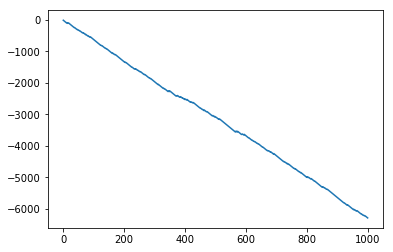

['Bryson DeChambeau',
 'Jason Kokrak',
 'Vijay Singh',
 'Anirban Lahiri',
 'Sergio Garcia',
 'Rory McIlroy']

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

num = -1

cum_sum = 0
y = []
for result in cost_iteration_results[num]['payouts']:
    cum_sum += result
    y.append(cum_sum)

plt.plot(y)
plt.show()
cost_iteration_results[num]['team']

In [149]:
len(cost_iteration_results)

501

In [150]:
new_team

['Bryson DeChambeau',
 'Jason Kokrak',
 'Vijay Singh',
 'Anirban Lahiri',
 'Sergio Garcia',
 'Rory McIlroy']

In [185]:
best_team = ['Henrik Stenson', 'Padraig Harrington', 'Sergio Garcia', 'Matthew Fitzpatrick', 'Tommy Fleetwood', 'Cameron Smith']

cost(best_team)

-2.9689999999999999

In [225]:
def random_combination_2(iterable, r, player_ls): 
    #Random selection from combinations
    #Remove player combinations from player list
    iterable = [x for x in iterable if x not in player_ls]
    
    iter_count = 0 
    combo_salary = 0
    salary_ls = []
    while combo_salary < 49000 or combo_salary > 50000:
        iter_count += 1
        if iter_count > 60000:
            if player_ls[0] == 'placeholder':
                print('placeholder error')
                
            else:
                print('combination impossible')
                
            return salary_ls
        
        if r == 5:
            combo_salary = salary_dict[player_ls[0]]
        elif r == 4:
            combo_salary = salary_dict[player_ls[0]] + salary_dict[players[1]]
        else:
            combo_salary = 0
        
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        team = tuple(pool[i] for i in indices)
        
        for t in team:
            combo_salary += salary_dict[t]
        
        salary_ls.append(tuple((team, combo_salary)))
    

    return tuple(pool[i] for i in indices)


def team_sim(team_ls):
    indices = np.arange(len(contest_array)).reshape(len(contest_array), 1)
    team_payout_ls = []
    
    team_ids_ls =[]
    for team in team_ls:
        
        team_ids = []

        for player in team:
            for key in pid_dict.keys():
                if pid_dict[key]['name'] == player:
                    team_ids.append(key)
        
        team_ids_ls.append(team_ids)
        
    lineup_payout_array = np.arange(len(team_ls)).reshape(-1,1)
    
    for i in tqdm(range(1,proj_array.shape[1])):

        #create dict of points 
        point_dict = dict(zip(proj_array[:,0], proj_array[:,i]))

        #select random int for replacement in contest array
        random_ls = []
        for team in team_ls:
            random_replacement = random.randint(0, len(contest_array) - 1)
            random_ls.append(random_replacement)

        #create_temp array for replacement
        temp_contest_array = contest_array
        
        for t, team_id in enumerate(team_ids_ls):
            random_num = random_ls[t]
            temp_contest_array[random_replacement] = team_id

        #create sim array of points from single simulation
        sim_array = np.vectorize(point_dict.__getitem__)(temp_contest_array)

        #sum up team points for simulation
        total_points = sim_array.sum(axis = 1).reshape((len(sim_array),1))

        #create add indicies to total points
        result_array = np.hstack((indices, total_points))

        #sort result array by points decending
        result_array = result_array[result_array[:, 1].argsort()[::-1]]

        #add payout array to results array
        result_array = np.hstack((result_array, payout_array))

        #revert result array back to being order by index
        result_array = result_array[result_array[:,0].argsort()]

        #append team result to team payout array
        iteration_payout_array = result_array[random_ls, -1].reshape(-1,1)
        lineup_payout_array = np.hstack((lineup_payout_array, iteration_payout_array))
        
           
    return lineup_payout_array


def find_first_player(top_players, num_players_to_return):
    for p, player in enumerate(top_players):
        team_ls = []
        for i in range(num_lineups_per_player):
            team_ls.append(random_combination_2(players, 5, [player]) + tuple((player,)))

        master_team_ls.append(team_ls)

        result_array = team_sim(team_ls)
        result_array = np.hstack(((np.full((num_lineups_per_player, 1), p)), result_array))

        if p == 0:
            player_result_array = result_array
        else:
            player_result_array = np.vstack((player_result_array, result_array))

    result_dict = {}
    for p, player in enumerate(top_players):
        temp_array = player_result_array[p * n:p * n + n]
        result_dict[player] = {'total': np.sum(temp_array)}

    result_df = pd.DataFrame()
    result_df['players'] = result_dict.keys()
    result_df['return'] = result_df['players'].apply(lambda x: result_dict[x]['total'])
    result_df.sort_values('return', ascending = False, inplace = True)
    result_df = result_df.head(num_players_to_return)
    
    return result_df['players'].values

def find_second_player(top_players, first_player, num_combos_to_return, player_result_array):
    result_df = pd.DataFrame(columns = ['combo', 'return'])
    for p, player in enumerate(top_players):
        team_ls = []
        for i in range(num_lineups_per_player):
            team_ls.append(random_combination_2(players, 4, [first_player, player]) + tuple((first_player, player)))
            
        master_team_ls.append(team_ls)
        
        result_array = team_sim(team_ls)
        result_array = np.hstack(((np.full((num_lineups_per_player, 1), p)), result_array))
        
        player_result_array = np.vstack((player_result_array, result_array))
        
    for p, player in enumerate(top_players):
        temp_array = player_result_array[p * n: p* n + n]
        combo_name = first_player + ', ' + player
        result_dict[combo_name] = {'total': np.sum(temp_array)}
        
        result_df.loc[p] = [combo_name, np.sum(temp_array)]
    
    result_df.sort_values('return', ascending = False, inplace = True)
    result_df = result_df.head(num_combos_to_return)
    
    return result_df, player_result_array

In [186]:
num_lineups_per_player = 150
master_team_ls = []

for p, player in enumerate(players[:10]):
    team_ls = []
    for i in range(num_lineups_per_player):
        team_ls.append(random_combination_2(players, 5, player) + tuple((player,)))
    
    master_team_ls.append(team_ls)
    
    result_array = team_sim(team_ls)
    result_array = np.hstack(((np.full((num_lineups_per_player, 1), p)), result_array))
    
    if p == 0:
        player_result_array = result_array
    else:
        player_result_array = np.vstack((player_result_array, result_array))
    
player_result_array

100%|██████████| 1000/1000 [04:44<00:00,  3.53it/s]


array([[  0,   0,  -8, ...,  -8,  12,  -8],
       [  0,   1,  -8, ...,  -8,   4,   4],
       [  0,   2,  -8, ...,  -8,   7,  -8],
       ..., 
       [  9, 147,  -8, ...,  -8,  -8,  -8],
       [  9, 148,  17, ...,  -8,  -8,  -8],
       [  9, 149,  -8, ...,  -8,  -8,  52]])

In [227]:
num_lineups_per_player = 150
n = num_lineups_per_player
master_team_ls = []


        
        

#top_players = find_first_player(players[:10], 1)
top_2_man_combos, player_result_array = find_second_player(players[:30], 'Brooks Koepka', 30, player_result_array)
top_2_man_combos

100%|██████████| 1000/1000 [04:50<00:00,  3.40it/s]


,combo,return
27,"Brooks Koepka, Russell Henley",-61272.0
28,"Brooks Koepka, Patrick Reed",-66541.0
9,"Brooks Koepka, Brooks Koepka",-70098.0
3,"Brooks Koepka, Rickie Fowler",-83300.0
0,"Brooks Koepka, Jordan Spieth",-115952.0
13,"Brooks Koepka, Adam Scott",-117170.0
16,"Brooks Koepka, Marc Leishman",-118525.0
12,"Brooks Koepka, Matt Kuchar",-142756.0
5,"Brooks Koepka, Jason Day",-150345.0
8,"Brooks Koepka, Sergio Garcia",-151190.0


In [228]:
dj_2_man_combos, dj_player_result_array = find_second_player(players[:30], 'Dustin Johnson', 30, player_result_array)
dj_2_man_combos

100%|██████████| 1000/1000 [04:55<00:00,  3.41it/s]


,combo,return
27,"Dustin Johnson, Russell Henley",-61272.0
28,"Dustin Johnson, Patrick Reed",-66541.0
9,"Dustin Johnson, Brooks Koepka",-70098.0
3,"Dustin Johnson, Rickie Fowler",-83300.0
0,"Dustin Johnson, Jordan Spieth",-115952.0
13,"Dustin Johnson, Adam Scott",-117170.0
16,"Dustin Johnson, Marc Leishman",-118525.0
12,"Dustin Johnson, Matt Kuchar",-142756.0
5,"Dustin Johnson, Jason Day",-150345.0
8,"Dustin Johnson, Sergio Garcia",-151190.0


In [188]:
for key in result_dict.keys():
    result_dict[key]['ownership'] = player_df['owned'].loc[player_df['name'] == key].values[0]
    result_dict[key]['salary'] = player_df['salary'].loc[player_df['name'] == key].values[0]
    result_dict[key]['mean_proj'] = sum(player_distro_dict[key][0]) / len(player_distro_dict[key][0])

In [189]:
result_dict

{'Brooks Koepka': {'mean_proj': 68.185000000000002,
  'ownership': 0.12,
  'salary': 9200,
  'total': -70098},
 'Dustin Johnson': {'mean_proj': 65.825000000000003,
  'ownership': 0.16,
  'salary': 11400,
  'total': -164914},
 'Henrik Stenson': {'mean_proj': 51.994999999999997,
  'ownership': 0.10000000000000001,
  'salary': 9800,
  'total': -192125},
 'Hideki Matsuyama': {'mean_proj': 57.365000000000002,
  'ownership': 0.16,
  'salary': 10500,
  'total': -287896},
 'Jason Day': {'mean_proj': 58.520000000000003,
  'ownership': 0.089999999999999997,
  'salary': 10400,
  'total': -150345},
 'Jon Rahm': {'mean_proj': 60.064999999999998,
  'ownership': 0.11,
  'salary': 10100,
  'total': -171542},
 'Jordan Spieth': {'mean_proj': 67.590000000000003,
  'ownership': 0.17999999999999999,
  'salary': 12000,
  'total': -115952},
 'Rickie Fowler': {'mean_proj': 64.939999999999998,
  'ownership': 0.25,
  'salary': 10700,
  'total': -83300},
 'Rory McIlroy': {'mean_proj': 66.635000000000005,
  'owne

In [183]:
cost_iteration_results[-1]

{'payouts': [4,
  -8,
  7,
  4,
  -8,
  -8,
  -8,
  7,
  4,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  12,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  4,
  4,
  7,
  -8,
  -8,
  -8,
  12,
  -8,
  -8,
  12,
  -8,
  12,
  7,
  -8,
  -8,
  -8,
  -8,
  17,
  4,
  4,
  -8,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  4,
  7,
  -8,
  -8,
  -8,
  7,
  7,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  4,
  -8,
  -8,
  -8,
  12,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  22,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  12,
  -8,
  -8,
  -8,
  -8,
  7,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  -8,
  4,
  -8,
  4,
  7,
  -8,
  -8,
  -8,
  -8,
  4,
  -8,
  22,
  -8,
  -8,
  7,
  -8,
  -8,
  -8,
  -8,
  -8,
  -8,
  4,
  -8